# Memorization vs Generalization

Neuronale Nete sollen sich keine Daten "merken" sondern lenren zu abstrahieren also generalisieren. 

In [2]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = False

Using TensorFlow backend.


Wir verwenden zu demonstrationszwecken das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 

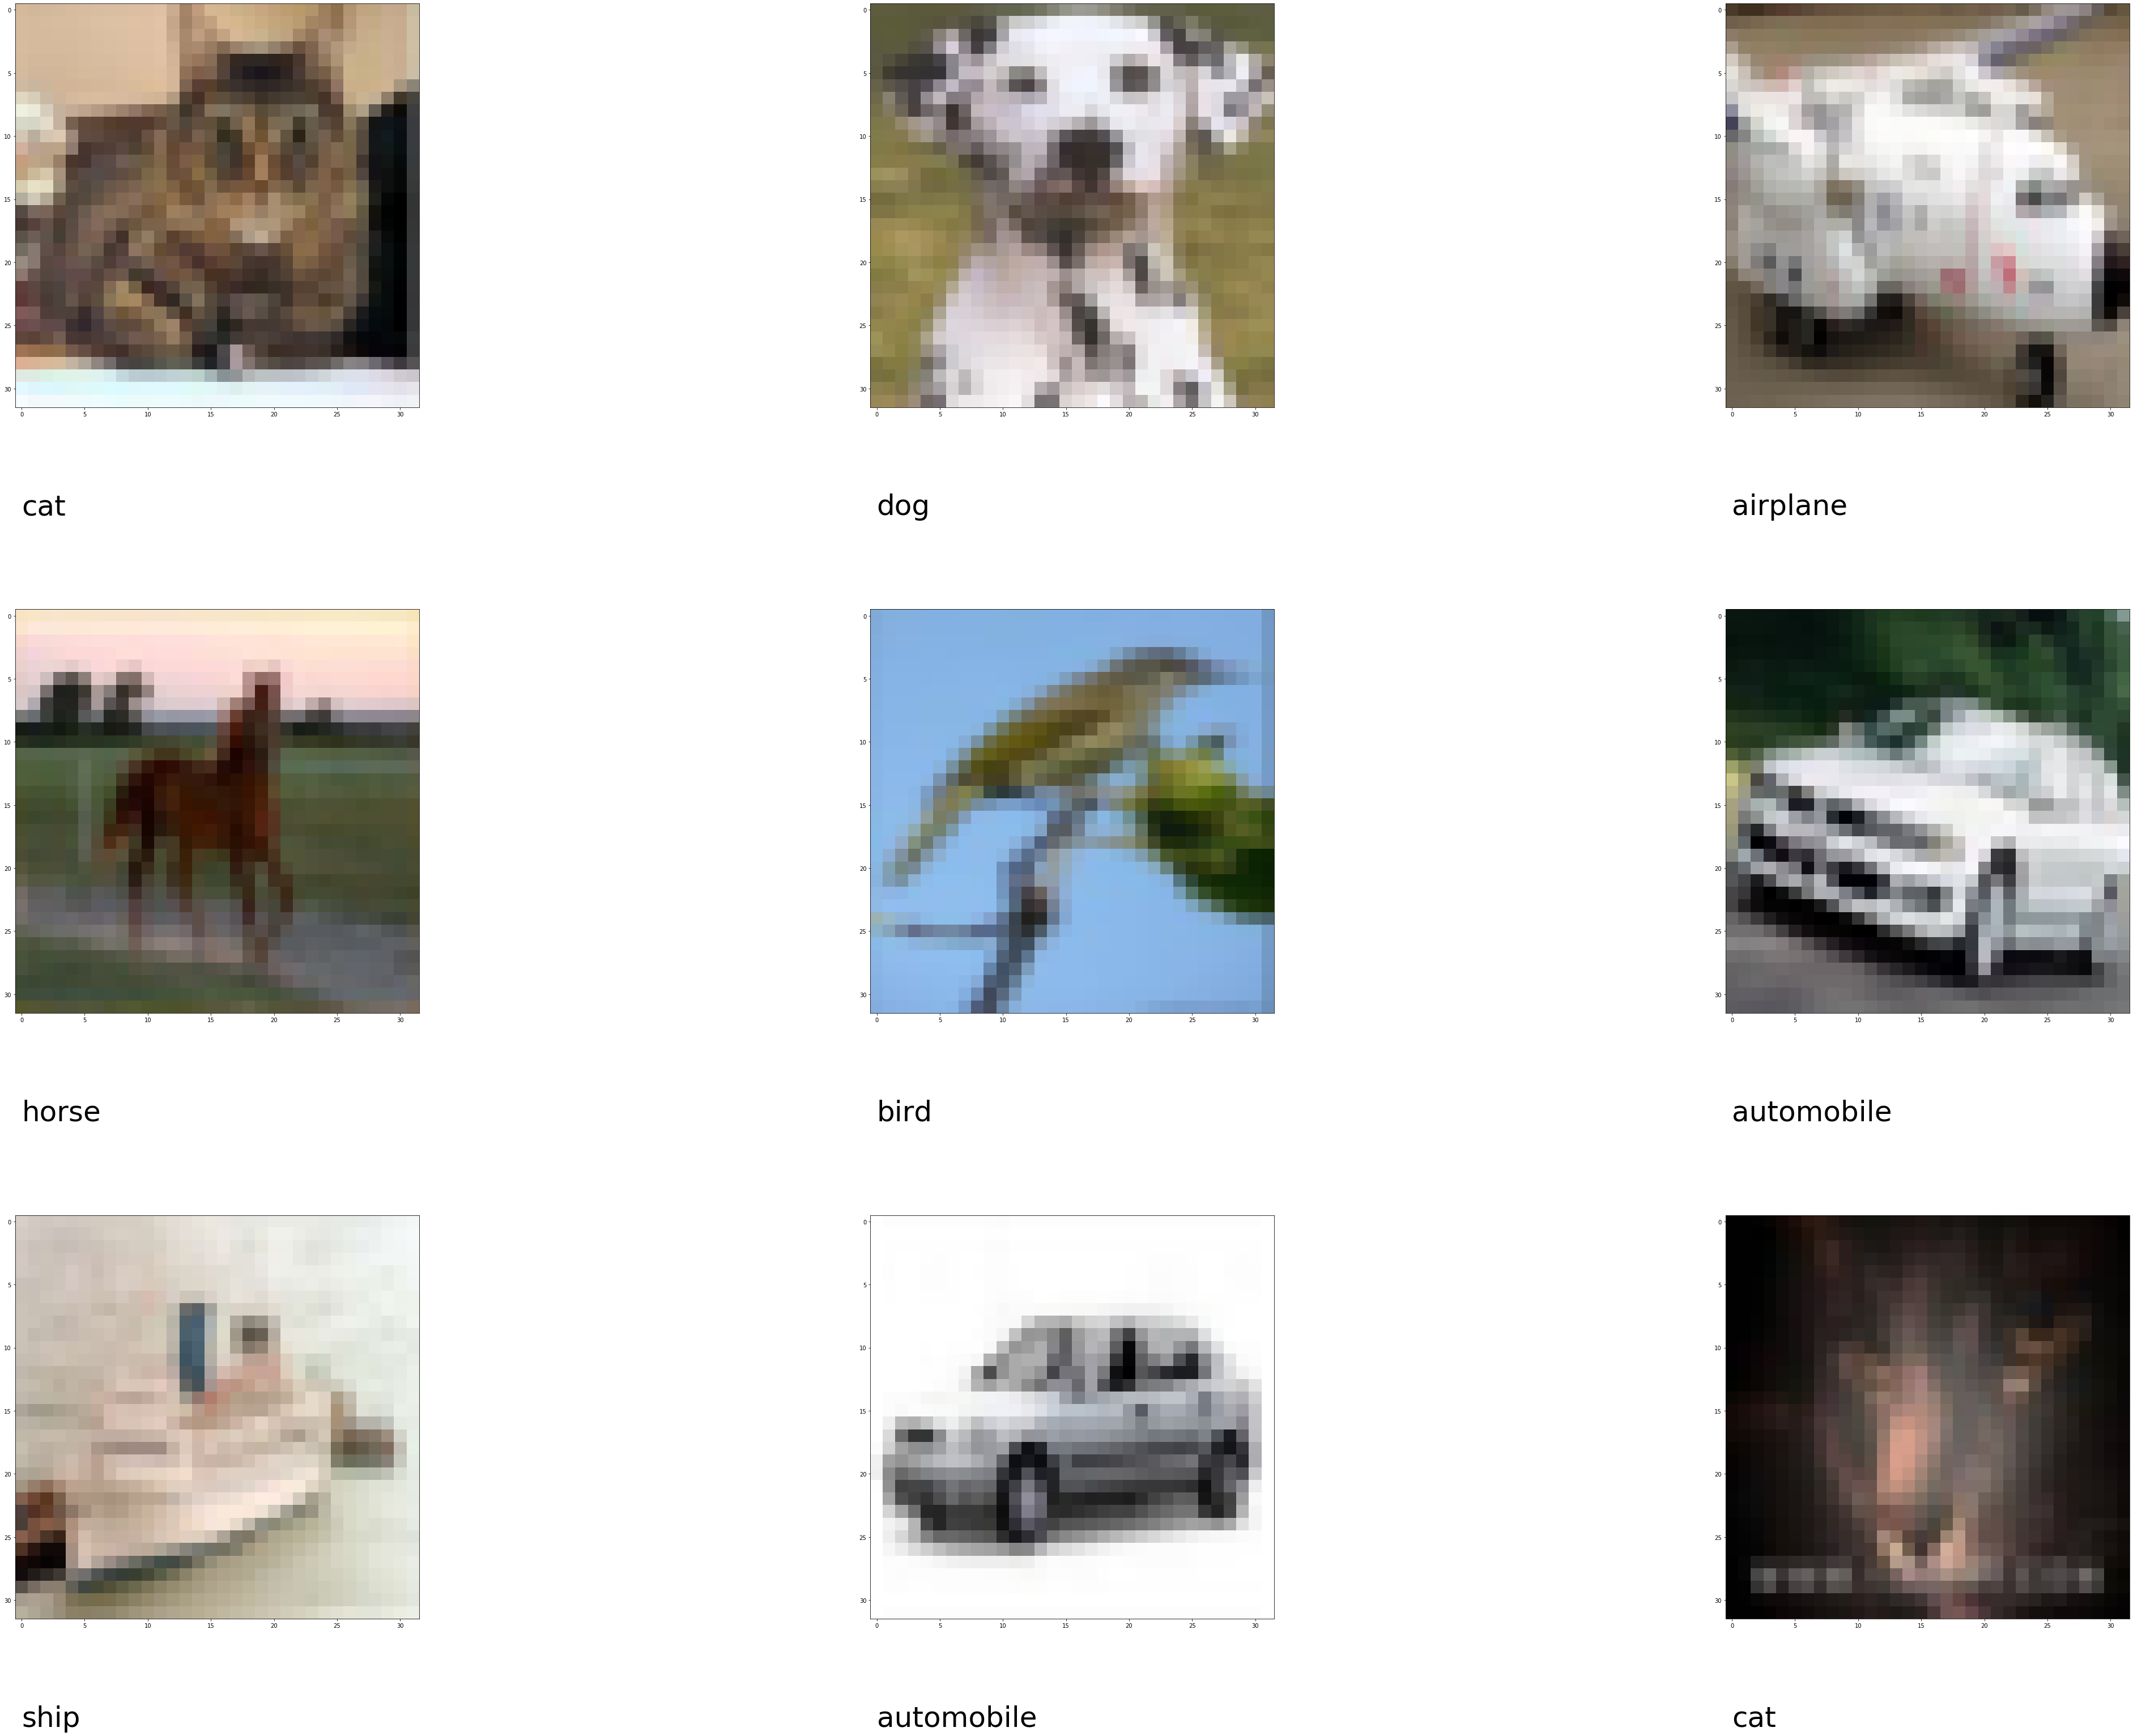

In [3]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



In [4]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


In [5]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

In [6]:
def create_model(conv1, conv2, conv3, dense):
    model = Sequential()
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if conv2 != 0:
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
    if conv3 != 0:
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')

In [7]:


if os.path.isfile('models/small') and not FORCE_BUILD_MODELS:
    model_small = load_model('models/small')
    with open('models/small_history.json') as file:
        history_small = json.load(file)
else:
    model_small = create_model(2, 0, 0, 64)
    history_small = model_small.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY))
    model_small.save('models/small')
    with open('models/small_history.json', 'w') as file:
        json.dump(history_small.history, file)
        history_small = history_small.history



W0707 00:32:24.099491 140529866995328 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 00:32:24.123788 140529866995328 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 00:32:24.176036 140529866995328 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0707 00:32:24.364104 140529866995328 deprecation_wrapper.py:119] From /home/robin/WVIN/.venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0

In [8]:
if os.path.isfile('models/random') and not FORCE_BUILD_MODELS:
    model_random = load_model('models/random')
    with open('models/random_history.json') as file:
        history_random = json.load(file)
else:
    model_random = create_model(32, 16, 0, 128)
    history_random = model_random.fit(trainX, trainY_shuffle, epochs=100, batch_size=64, validation_data=(testX, testY))
    model_random.save('models/random')
    with open('models/random_history.json', 'w') as file:
        json.dump(history_random.history, file)
        history_random = history_random.history

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
14528/50000 [=======>......................] - ETA: 1:00 - loss: 2.3210 - acc: 0.0996

KeyboardInterrupt: 

In [ ]:
plot_summary(history_small)